In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
import datetime
from dateutil.parser import parse
pd.options.display.max_rows=6

In [2]:
#using instructions from: https://www.dataquest.io/blog/web-scraping-tutorial-python/

page= requests.get("http://www.ci.austin.tx.us/health/restaurant/scores.cfm?begdate=01%2F17%2F2016&enddate=01%2F17%2F2017&selpara=0&estabname=&estabcity=AUSTIN&estabzip=All&Submit=Search")

page
#<Response [200]>
#page.status_code
len(page.content)

1761966

In [3]:
soup=BeautifulSoup(page.content, 'html.parser')

In [4]:
print(soup.prettify())

<!DOCTYPE doctype html>
<!--[if lt IE 7 ]><html class="ie ie6" lang="en"> <![endif]-->
<!--[if IE 7 ]><html class="ie ie7" lang="en"> <![endif]-->
<!--[if IE 8 ]><html class="ie ie8" lang="en"> <![endif]-->
<!--[if (gte IE 9)|!(IE)]><!-->
<html lang="en">
 <!--<![endif]-->
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="noindex,nofollow" name="robots"/>
  <meta content="noindex,nofollow" name="googlebot"/>
  <title>
   City of Austin - Restaurant Inspection Scores
  </title>
  <meta content="width=device-width, initial-scale=1.0, minimum-scale=1.0" name="viewport">
   <meta content="IE=7, IE=9" http-equiv="X-UA-Compatible">
    <script src="https://ajax.googleapis.com/ajax/libs/jquery/1.12.0/jquery.min.js">
    </script>
    <style>
     html {
font-family: Arial,Helvetica,sans-serif;
font-size:62.5%;
}
 
body {
margin:0;
padding:0;
}
 
iframe { 
        border: none; 
        margin: 0; 
        padding: 0;
}
 
#page {
margin:0;
padding:

In [5]:
rows=soup.find_all('tr')
print(len(rows))
print('rows0',rows[1])
print('several',*rows[1:2], sep='\n')

8242
rows0 <tr bgcolor="#F0F0F0" valign="top">
<td>"CB's" at Stubb's Bar-B-Q</td>
<td>809  RED RIVER ST    </td>
<td>AUSTIN</td>
<td>78701</td>
<td>09/29/2016</td>
<td align="center">99   </td>
</tr>
several
<tr bgcolor="#F0F0F0" valign="top">
<td>"CB's" at Stubb's Bar-B-Q</td>
<td>809  RED RIVER ST    </td>
<td>AUSTIN</td>
<td>78701</td>
<td>09/29/2016</td>
<td align="center">99   </td>
</tr>


In [6]:
cells=rows[1].find_all('td')
print(*cells[0:6], sep='\n')

<td>"CB's" at Stubb's Bar-B-Q</td>
<td>809  RED RIVER ST    </td>
<td>AUSTIN</td>
<td>78701</td>
<td>09/29/2016</td>
<td align="center">99   </td>


In [69]:
df = pd.DataFrame(columns=('name', 'zip','date','score'))
#print(df.head())
for rn, row in enumerate(rows[1:]):
    cells=row.find_all('td')
    df.loc[rn,'name']=str(cells[0]).lstrip('<td>').rstrip('</td>')
    df.loc[rn,'zip']=str(cells[3]).lstrip('<td>').rstrip('</td>')
    df.loc[rn,'date']=str(cells[4]).lstrip('<td>').rstrip('</td>')
    df.loc[rn,'score']=str(cells[5]).lstrip('<td align="center">').rstrip('</td>')
df.loc[1:10,:]

Empty DataFrame
Columns: [name, zip, date, score]
Index: []


name    zip        date  score
1   "CB's" at Stubb's Bar-B-Q  78701  05/18/2016  99   
2               'Bout Time II  78752  10/28/2016  83   
3               'Bout Time II  78752  05/20/2016  89   
..                        ...    ...         ...    ...
8      183 Grill Austin Gyros  78729  08/08/2016  95   
9      183 Grill Austin Gyros  78729  01/28/2016  95   
10               1st Food Mar  78704  11/14/2016  93   

[10 rows x 4 columns]

In [8]:
datetimeObj=parse(df.loc[1,'date'])
datetimeObj2=parse(df.loc[2,'date'])
print(datetimeObj-datetimeObj2)

#somedate.strftime('%Y-%m-%d')

-163 days, 0:00:00


In [ ]:
# Make pairs with days diff and score diff between the two
nameL=list(set(df['name']))
zipRatio=[]
suspectRest=[]
#print(nameL[0:3])
for name in nameL[0:]:
    #print('name',name)
    zipL=list(set(df.loc[df['name']==name,'zip']))
    for zip0 in zipL:
        df0=df.loc[((df['name']==name) & (df['zip']==zip0)),:]
        indexL=df0.index.values.tolist()
        pairL=[[item1,item2] for item1,item2 in zip(indexL,indexL[1:])]    
        #print(pairL)
        for pair in pairL:
            scoreDiff=float(df0.loc[pair[0],'score'])-float(df0.loc[pair[1],'score'])
            dayDiff=parse(df0.loc[pair[0],'date'])-parse(df0.loc[pair[1],'date'])
            dayDiff=float(str(dayDiff.days))
            if abs(dayDiff)<1: 
                dayDiff=1
            #scorePair=dfname.loc[dfname['date']==date,'score']
            #print(pair,'  scoreDiff=',scoreDiff,'  dayDiff=',dayDiff)  
            ratio=round(scoreDiff/(dayDiff+.1),2)
            date0=parse(df0.loc[pair[0],'date']) #the latter of two dates
            zipRatio.append([date0,float(zip0),ratio,pair])
            if dayDiff<100 and abs(ratio)>.5:
                suspectRest.append([name,zip0,ratio,pair])
                print(name,zip0,pair,'score/day=',scoreDiff,'/',dayDiff)
                

In [145]:
print(zipRatio[0:3],sep='\n')

El Meson 78744 [2467, 2468] score/day= 20.0 / 14.0
McDonald's   #4941 78704 [4580, 4581] score/day= 25.0 / 19.0
Star of India Rest.&amp;Bar; 78757 [6538, 6539] score/day= 24.0 / 15.0
Little Barrel and Brown 78704 [4219, 4220] score/day= 17.0 / 22.0
Little Barrel and Brown 78704 [4221, 4222] score/day= 16.0 / 18.0
La Posada Mexican Restauran 78745 [4055, 4056] score/day= 19.0 / 20.0
Blake Manor Food Mar 78653 [824, 825] score/day= 26.0 / 20.0
Wild Wood Bakehouse 78705 [8086, 8087] score/day= 26.0 / 14.0
Poco Loco Supermercado 78745 [5516, 5517] score/day= 22.0 / 1
Kim Phung Vietnamese and Chinese Restauran 78752 [3894, 3895] score/day= 21.0 / 16.0
Cedar Food Mar 78744 [1249, 1250] score/day= 19.0 / 12.0
Los Potrillos Restauran 78753 [4335, 4336] score/day= 37.0 / 17.0
Mikado Ryotei 78758 [4713, 4714] score/day= 25.0 / 32.0
Joy Eas 78741 [3766, 3767] score/day= 25.0 / 19.0
Mama Fu's 2nd Stree 78701 [4439, 4440] score/day= 24.0 / 15.0
McDonalds 78705 [4606, 4607] score/day= 26.0 / 14.0
Au

In [160]:
from pylab import plot,show
import pylab as plb
import numpy as np
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq

Pylab samples
http://jakevdp.github.io/mpl_tutorial/tutorial_pages/tut1.html

In [163]:
#zipsL=zipRatio[2][1]
print('zipRAtio',zipRatio[1:2])
zipsL=[row[1] for row in zipRatio if row[2]<40]
ratioL=[row[2] for row in zipRatio if row[2]<40] #exclude outlier
print(ratioL[1:5])


print(len(zipsL[:]))

# data generation
#data = vstack((rand(150,2) + array([.5,.5]),rand(150,2)))
print(len(data))
print(type(data))
data.shape

data0=array([zipsL[:],ratioL[:]])
#print(data[0:5],'len',len(data))
data=np.transpose(data0)
print(len(data))
print(type(data))
print(data.shape)
data[0:4]


zipRAtio [[datetime.datetime(2016, 9, 8, 0, 0), 78703.0, 0.02, [4527, 4528]]]
[0.02, -0.01, 0.04, 0.02]


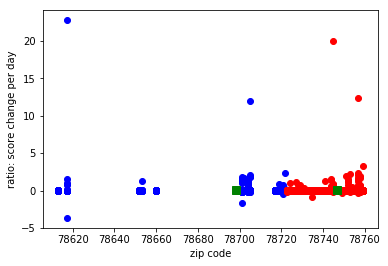

In [167]:
# computing K-Means with K = 2 (2 clusters)
centroids,_ = kmeans(data,2)
# assign each sample to a cluster
idx,_ = vq(data,centroids)

# some plotting using numpy's logical indexing
plot(data[idx==0,0],data[idx==0,1],'ob',
     data[idx==1,0],data[idx==1,1],'or')
plot(centroids[:,0],centroids[:,1],'sg',markersize=8)
plb.ylabel('ratio: score change per day')
plb.xlabel('zip code')
show()

In [ ]:
#zipsL=zipRatio[2][1]
#suspectRest.append([name,zip0,ratio,pair])
#Plot ratios in time vs zip code plane with colorcoding for ratio level
print('zipRAtio',zipRatio[1:2])
zipsL=[row[1] for row in zipRatio if row[2]<40]
ratioL=[row[2] for row in zipRatio if row[2]<40] #exclude outlier
print(ratioL[1:5])


print(len(zipsL[:]))

# data generation
#data = vstack((rand(150,2) + array([.5,.5]),rand(150,2)))
print(len(data))
print(type(data))
data.shape

data0=array([zipsL[:],ratioL[:]])
#print(data[0:5],'len',len(data))
data=np.transpose(data0)
print(len(data))
print(type(data))
print(data.shape)
data[0:4]

In [27]:
print(df.index.values.tolist())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [10]:
date0=parse('01/01/2016')
#daysL=[parse(date) for date in df.loc[:,'date']]

In [13]:

df.assign(days)

NameError: name 'days' is not defined

In [48]:
df['name'=='1-Stop Food Store']

KeyError: False

In [ ]:

weather = pd.DataFrame({
        "period": periods, 
        "short_desc": short_descs, 
        "temp": temps, 
        "desc":descs
    })
weather